# Propaganda Classification using ML and DL Modeling

In [1]:
path = "C:/Users/dell/Desktop/MRP/Codes/faheem/"

## 1. Import Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import nltk
import string
import operator
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

nltk.download('stopwords')
nltk.download('vader_lexicon')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 2. Import Data

In [3]:
## reading tsv datasets
train_df = pd.read_csv(path + "proppy_1.0.train.tsv", sep='\t', header=None)
val_df = pd.read_csv(path + "proppy_1.0.dev.tsv", sep='\t', header=None)
test_df = pd.read_csv(path + "proppy_1.0.test.tsv", sep='\t', header=None)

In [4]:
## getting column names
column_names = ['text', 'location', 'tone', 'date', 'ID', 'URL', 'MBFC_factuality_label', 'URL.1', 
                'MBFC_factuality_label.1', 'URL_to_MBFC_page', 'source_name', 'MBFC_notes_about_source', 
                'MBFC_bias_label', 'source_URL', 'propaganda_label']

## applying column names to the dataset
train_df.columns = column_names; val_df.columns = column_names; test_df.columns = column_names

In [5]:
## getting column names
column_names = ['text', 'location', 'tone', 'date', 'ID', 'URL', 'MBFC_factuality_label', 'URL.1', 
                'MBFC_factuality_label.1', 'URL_to_MBFC_page', 'source_name', 'MBFC_notes_about_source', 
                'MBFC_bias_label', 'source_URL', 'propaganda_label']

## applying column names to the dataset
train_df.columns = column_names; val_df.columns = column_names; test_df.columns = column_names

In [6]:
## shape of the datasets
print("shape.......")
print("train -- {}, val -- {}, test -- {}".format(train_df.shape, val_df.shape, test_df.shape))

shape.......
train -- (35986, 15), val -- (5125, 15), test -- (10159, 15)


In [7]:
## getting top 5 rows
train_df.head(5)

,text,location,tone,date,ID,URL,MBFC_factuality_label,URL.1,MBFC_factuality_label.1,URL_to_MBFC_page,source_name,MBFC_notes_about_source,MBFC_bias_label,source_URL,propaganda_label
0,"Et tu, Rhody? A recent editorial in the Provi...","Rhode Island, United States",-3.181818,2018-02-02,727600136,http://www.courant.com/opinion/editorials/hc-e...,unknown,"Editorial: Why, Rhode Island, Why?",HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
1,A recent post in The Farmington Mirror — our t...,"Rhode Island, United States",-0.424328,2018-02-17,731714618,http://www.courant.com/features/hc-fea-avoidin...,Teresa M. Pelham,A Tip For Navigating The Dreaded School Drop-O...,HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
2,"President Donald Trump, as he often does while...","Florida, United States",-2.469136,2018-02-17,731714635,http://www.courant.com/nation-world/ct-trump-f...,Josh Dawsey,Trump focuses on praising first responders in ...,HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
3,"February is Black History Month, and nothing l...","Bristol, Bristol, City of, United Kingdom",-0.894632,2018-02-06,728627182,http://www.courant.com/entertainment/museums-g...,Susan Dunne,"African Slave-Trading Center, Frederick Dougla...",HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
4,"The snow was so heavy, whipped up by gusting w...","Connecticut, United States",-4.800000,2018-02-06,728627443,http://www.courant.com/weather/hc-br-blizzard-...,Nicholas Rondinone,"40 Years Ago, Blizzard Of '78 Walloped Connect...",HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1


### 2.1 info

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35986 entries, 0 to 35985
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   text                     35986 non-null  object 
 1   location                 35986 non-null  object 
 2   tone                     35986 non-null  float64
 3   date                     35986 non-null  object 
 4   ID                       35986 non-null  int64  
 5   URL                      35986 non-null  object 
 6   MBFC_factuality_label    26902 non-null  object 
 7   URL.1                    35986 non-null  object 
 8   MBFC_factuality_label.1  35986 non-null  object 
 9   URL_to_MBFC_page         35986 non-null  object 
 10  source_name              35986 non-null  object 
 11  MBFC_notes_about_source  29979 non-null  object 
 12  MBFC_bias_label          35986 non-null  object 
 13  source_URL               35986 non-null  object 
 14  propaganda_label      

### 2.2 optimal column selection

- The above training dataset has total of 15 columns/features.
- The most important features out of 15 are the input text ("text"), headline ("URL.1"), and the output label (propaganda_label).
- We I am removing the rest columns and keeping the above mention one.

In [9]:
## columns to keep
col_to_keep = ["text", "URL.1", "propaganda_label"]

train_df = train_df[col_to_keep]; val_df = val_df[col_to_keep]; test_df = test_df[col_to_keep]

## shape of the datasets
print("shape.......")
print("train -- {}, val -- {}, test -- {}".format(train_df.shape, val_df.shape, test_df.shape))

shape.......
train -- (35986, 3), val -- (5125, 3), test -- (10159, 3)


## 3. Data Cleaning

### 3.1 missing value count

In [10]:
def null_val_table(df):
    """
    This function geenrates all the null values counts in a dataframe from a given dataframe.
    """
    #getting missing value counts
    count = df.isnull().sum()
    #getting missing value percentage
    percentage = 100 * ((df.isnull().sum()) / (df.shape[0]))
    #creating dataframe and renaming column
    table = pd.concat([count, percentage], axis=1).rename(columns = {0:"missing_count", 1:"missing_percentage"})
    table = table[table['missing_count'] != 0]
    
    return table.sort_values("missing_count", ascending=False).round(3)

In [11]:
print(null_val_table(train_df))
print(null_val_table(val_df))
print(null_val_table(test_df))

Empty DataFrame
Columns: [missing_count, missing_percentage]
Index: []
Empty DataFrame
Columns: [missing_count, missing_percentage]
Index: []
Empty DataFrame
Columns: [missing_count, missing_percentage]
Index: []


**None of the column/feature has missing value present in the dataset.**

### 3.2 Duplicate Row Analysis

In [12]:
print(train_df[train_df.duplicated()])
print(val_df[val_df.duplicated()])
print(test_df[test_df.duplicated()])

Empty DataFrame
Columns: [text, URL.1, propaganda_label]
Index: []
Empty DataFrame
Columns: [text, URL.1, propaganda_label]
Index: []
Empty DataFrame
Columns: [text, URL.1, propaganda_label]
Index: []


**There are no duplicate values present in the dataset.**

## 4. Target Label Analysis

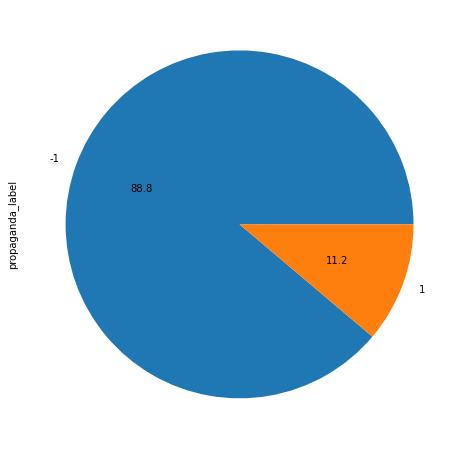

In [13]:
train_data = train_df['propaganda_label'].value_counts(
    normalize=True).plot(kind='pie', autopct="%.1f", figsize=(8,8))

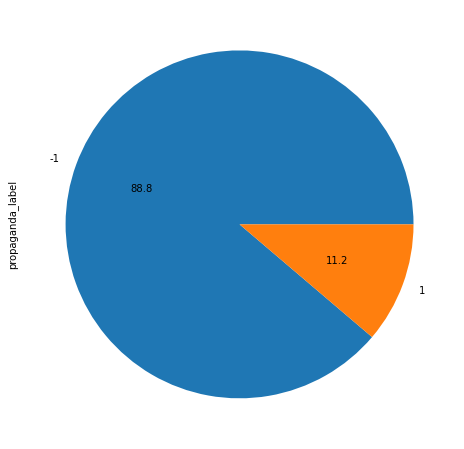

In [14]:
val_data = val_df['propaganda_label'].value_counts(
    normalize=True).plot(kind='pie', autopct="%.1f", figsize=(8,8))

## Observarions:

- "-1" represents no propaganda, and "1" represents yes propaganda.
- The class is highly imbalance as only 11.2% of text consists of propaganda yes.

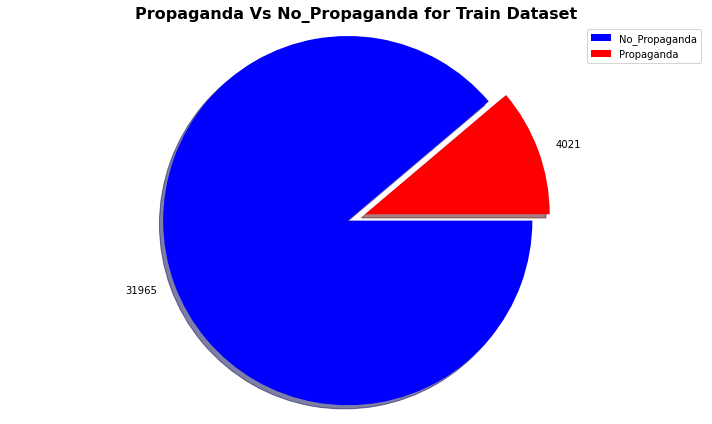

-1    31965
 1     4021
Name: propaganda_label, dtype: int64

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
tar=train_df['propaganda_label'].value_counts()
values = [tar[-1],tar[1]]
colors = ['b', 'r']

explode = (0.1, 0)
plt.title('Propaganda Vs No_Propaganda for Train Dataset',fontweight="bold", fontsize=16)
labels = ['No_Propaganda', 'Propaganda']
patches, texts = plt.pie(values, colors=colors, labels= values,explode=explode,counterclock=False, shadow=True)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()
tar

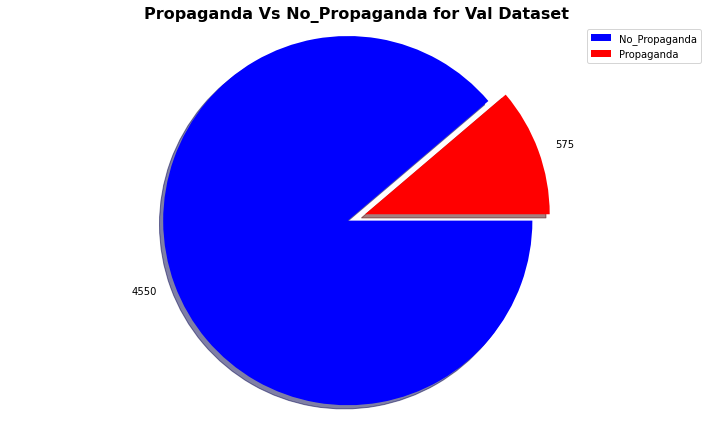

-1    4550
 1     575
Name: propaganda_label, dtype: int64

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
tar1=val_df['propaganda_label'].value_counts()
values = [tar1[-1],tar1[1]]
colors = ['b', 'r']

explode = (0.1, 0)
plt.title('Propaganda Vs No_Propaganda for Val Dataset',fontweight="bold", fontsize=16)
labels = ['No_Propaganda', 'Propaganda']
patches, texts = plt.pie(values, colors=colors, labels= values,explode=explode,counterclock=False, shadow=True)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()
tar1

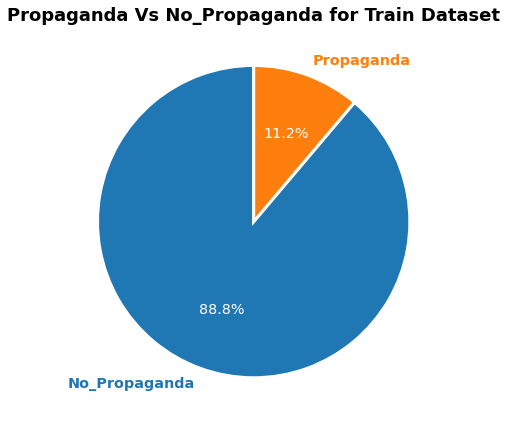

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
x = [31965, 4021]
labels = ['No_Propaganda', 'Propaganda']

patches, texts, pcts = ax.pie(
    x, labels=labels, autopct='%.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90)

for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
ax.set_title('Propaganda Vs No_Propaganda for Train Dataset', fontsize=18,fontweight="bold")
plt.tight_layout()

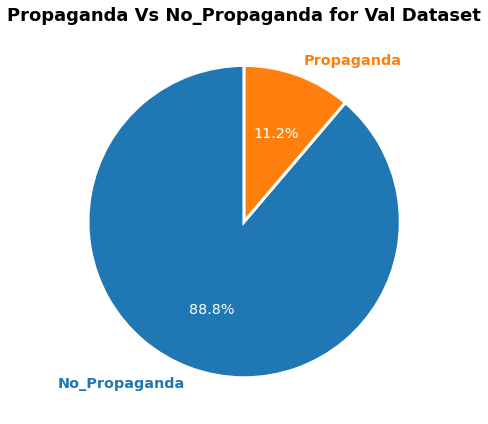

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
x = [4550, 575]
labels = ['No_Propaganda', 'Propaganda']

patches, texts, pcts = ax.pie(
    x, labels=labels, autopct='%.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90)

for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
ax.set_title('Propaganda Vs No_Propaganda for Val Dataset', fontsize=18,fontweight="bold")
plt.tight_layout()

## 5. Text Preprocessing

### 5.1 merging of text columns

In [19]:
## i have added the headlines and text column to get a proper set of text
train_df["final_text"] = train_df['URL.1'] + " " + train_df['text']
val_df["final_text"] = val_df['URL.1'] + " " + val_df['text']
test_df["final_text"] = test_df['URL.1'] + " " + test_df['text']

### 5.2 examples of text

In [20]:
train_df[train_df['propaganda_label'] == -1]["final_text"].values[0]

'Editorial: Why, Rhode Island, Why? Et tu, Rhody?  A recent editorial in the Providence Journal cataloged everything it could find wrong with Connecticut and ended with this suggestion: “Gov. Gina Raimondo should see if at least some of those jobs could come to Rhode Island. It is certainly less risky than the Nutmeg State.”  We beg your pardon.  The state with world-famous pension problems and persistent economic issues of its own is “less risky”?  The Journal itself reported just a few weeks ago on Rhode Island’s own significant economic problems, which in many ways reflect Connecticut’s.  Rhode Island enjoys a legacy of corruption that not even Connecticut can match. The ProJo won a Pulitzer Prize in 1994 for uncovering widespread corruption within its own court system.  What, exactly, is to be gained from moving to Rhode Island?  Like Connecticut, Rhode Island has an income tax and an estate tax with comparable rates. (Forbes magazine listed it as one of the states “Where Not To Di

### Observations:

- From the above text we can see that the text consists of stopwords, punctuations, special characters, numbers, and combination of alpha numeric values.
- We must perform text preprocessing methodology to remove the unwanted values and characters.

### 5.3 lowercasing the text

In [21]:
## lowercasing text
train_df['preprop_text'] = train_df['final_text'].str.lower()
val_df['preprop_text'] = val_df['final_text'].str.lower()
test_df['preprop_text'] = test_df['final_text'].str.lower()

### 5.4 decontraction of words

In [22]:
## using regex to decontraction of each and every contracted words

train_df['preprop_text'] = train_df['preprop_text'].str.replace(r"won\'t", "will not").str.replace(
    r"can\'t", "can not").str.replace(r"n\'t", " not").str.replace(r"\'re", " are").str.replace(
    "\’s", " is").str.replace(r"\'d", " would").str.replace(r"\'ll", " will").str.replace(
    r"\'t", " not").str.replace(r"\'ve", " have").str.replace(r"\'m", " am").str.replace("\'s", " is")

val_df['preprop_text'] = val_df['preprop_text'].str.replace(r"won\'t", "will not").str.replace(
    r"can\'t", "can not").str.replace(r"n\'t", " not").str.replace(r"\'re", " are").str.replace(
    "\’s", " is").str.replace(r"\'d", " would").str.replace(r"\'ll", " will").str.replace(
    r"\'t", " not").str.replace(r"\'ve", " have").str.replace(r"\'m", " am").str.replace("\'s", " is")

test_df['preprop_text'] = test_df['preprop_text'].str.replace(r"won\'t", "will not").str.replace(
    r"can\'t", "can not").str.replace(r"n\'t", " not").str.replace(r"\'re", " are").str.replace(
    "\’s", " is").str.replace(r"\'d", " would").str.replace(r"\'ll", " will").str.replace(
    r"\'t", " not").str.replace(r"\'ve", " have").str.replace(r"\'m", " am").str.replace("\'s", " is")

### 5.5 removal of special characters and punctuation

In [23]:
## removal of all special characters and punctuation
train_df['preprop_text'] = train_df['preprop_text'].str.replace(r'-', ' ').str.replace(r'[^\w\s]', '')
val_df['preprop_text'] = val_df['preprop_text'].str.replace(r'-', ' ').str.replace(r'[^\w\s]', '')
test_df['preprop_text'] = test_df['preprop_text'].str.replace(r'-', ' ').str.replace(r'[^\w\s]', '')

### 5.6 removal of stopwords

In [24]:
## removal of stopwords present in the stopwords object
print(stopwords)

train_df["preprop_text"] = train_df["preprop_text"].apply(
    lambda x : ' '.join(e for e in x.split() if e not in stopwords))

val_df["preprop_text"] = val_df["preprop_text"].apply(
    lambda x : ' '.join(e for e in x.split() if e not in stopwords))

test_df["preprop_text"] = test_df["preprop_text"].apply(
    lambda x : ' '.join(e for e in x.split() if e not in stopwords))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### 5.7 removal of alphanumeric and numeric characters

In [25]:
## removing stopwords
train_df["preprop_text"] = train_df["preprop_text"].str.replace(r" \d+", "")
val_df["preprop_text"] = val_df["preprop_text"].str.replace(r" \d+", "")
test_df["preprop_text"] = test_df["preprop_text"].str.replace(r" \d+", "")

### 5.8 stemming 

In [26]:
%%time
ps = PorterStemmer()
train_df["preprop_text"] = train_df["preprop_text"].apply(lambda x : " ".join(ps.stem(val) for val in x.split()))
val_df["preprop_text"] = val_df["preprop_text"].apply(lambda x : " ".join(ps.stem(val) for val in x.split()))
test_df["preprop_text"] = test_df["preprop_text"].apply(lambda x : " ".join(ps.stem(val) for val in x.split()))

Wall time: 5min


In [27]:
train_df[train_df['propaganda_label'] == -1]["preprop_text"].values[0]

'editori rhode island et tu rhodi recent editori provid journal catalog everyth could find wrong connecticut end suggest gov gina raimondo see least job could come rhode island certainli less riski nutmeg state beg pardon state world famou pension problem persist econom issu less riski journal report week ago rhode island signific econom problem mani way reflect connecticut rhode island enjoy legaci corrupt even connecticut match projo pulitz prize uncov widespread corrupt within court system exactli gain move rhode island like connecticut rhode island incom tax estat tax compar rate forb magazin list one state die connecticut made list connecticut rhode island interdepend limit except interst economi creat electr boat groton border war littl bloodsh joke rhode island size mayb honest connecticut doesnt realli lot go depart either littl interst competit fine connecticut suffer rhode island new england matter connecticut lose resid troubl rate rhode island outmigr problem ocean state ex

## 6. Word Cloud

In [28]:
def wordClouds(text):
    """
    This function creates the word cloud by taking all words into consideration.
    """
    #Creating a list of words present in the text
    corpus = [line.split() for line in text.values]
    ## getting all sentences in one text
    all_words = " ".join(i for line in corpus for i in line)
            
    #plotting wordcloud
    wordcloud = WordCloud(width = 1200, height = 800, stopwords = set(STOPWORDS), min_font_size = 30,
                          background_color = "black").generate(all_words)
    #display image
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

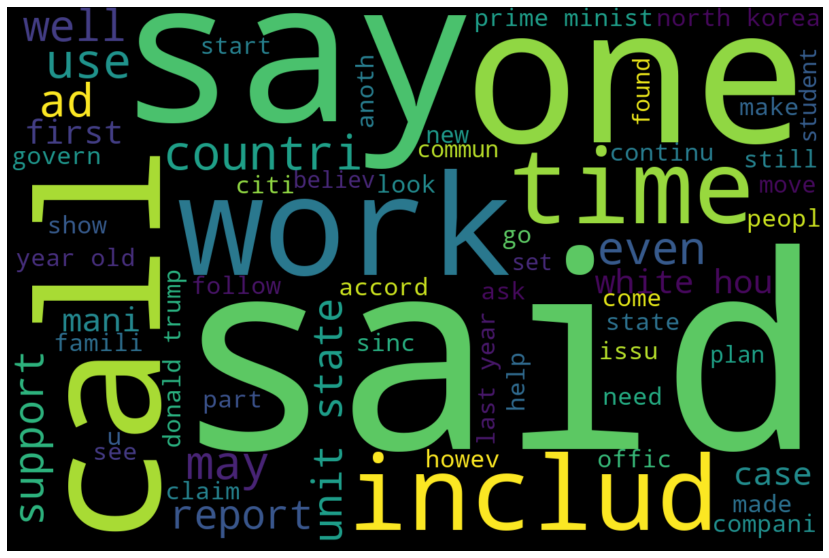

In [29]:
wordClouds(train_df[train_df['propaganda_label'] == -1]["preprop_text"]) ## plotting word clouds

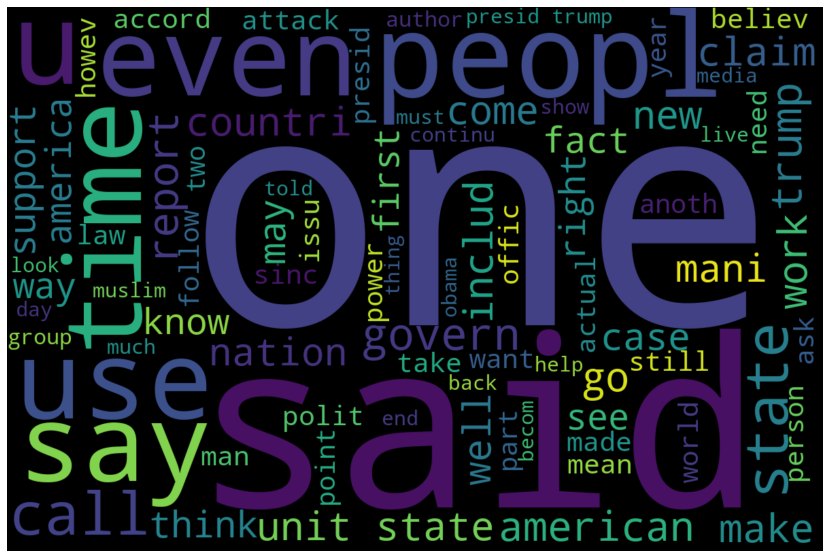

In [30]:
wordClouds(train_df[train_df['propaganda_label'] == 1]["preprop_text"])

## 7. n-gram analysis

In [31]:
"""function to generate ngrams and plot the data"""
def generate_ngrams(text, n_gram):
    #generating token
    word = [token for token in str(text).lower().split(" ") if token != ""]
    #generating ngrams
    ngrams = zip(*[word[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]



def freq_ngrams(text, n_gram, range, title):
    """parameters : text, number of ngrams(1,2,3), range(top ngrams)
       return : plot of word vs no of occurance
    """
    freq_dict = defaultdict(int)
    for sent in text:
        for w in generate_ngrams(sent,n_gram):
            freq_dict[w] += 1
    freq_dict = dict(freq_dict)
    #sorting dict to descending order
    qstn_txt = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
    qstn_txt.columns = ["word", "wordcount"]
    fig = plt.figure(figsize = (20,5))
    plt.bar(qstn_txt.word[0:range], qstn_txt.wordcount[0:range])
    plt.xticks(rotation = 90)
    plt.xlabel("words", fontsize=15)
    plt.xlabel("count", fontsize=15)
    plt.title(title, fontsize=20)
    return plt.show()

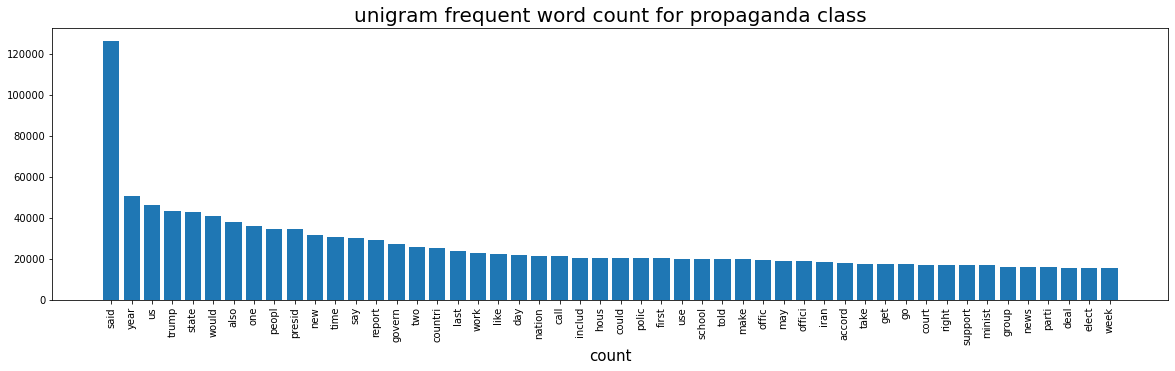

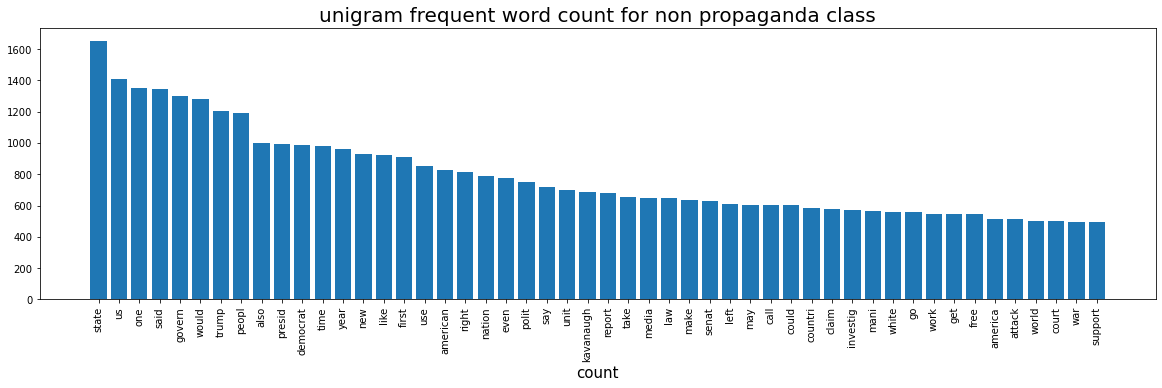

In [32]:
freq_ngrams(train_df[train_df['propaganda_label'] == -1]["preprop_text"], n_gram=1, range=50, 
            title="unigram frequent word count for propaganda class")
freq_ngrams(val_df[val_df['propaganda_label'] == 1]["preprop_text"], n_gram=1, range=50, 
            title="unigram frequent word count for non propaganda class")

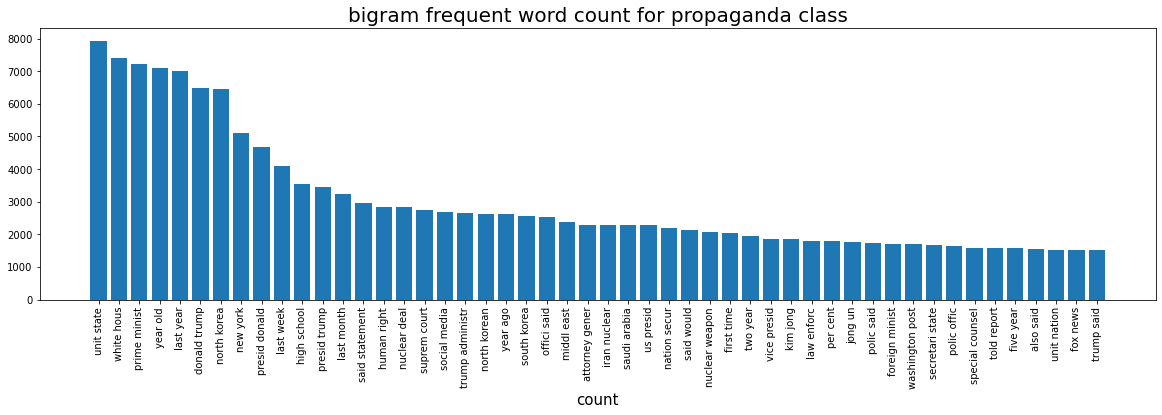

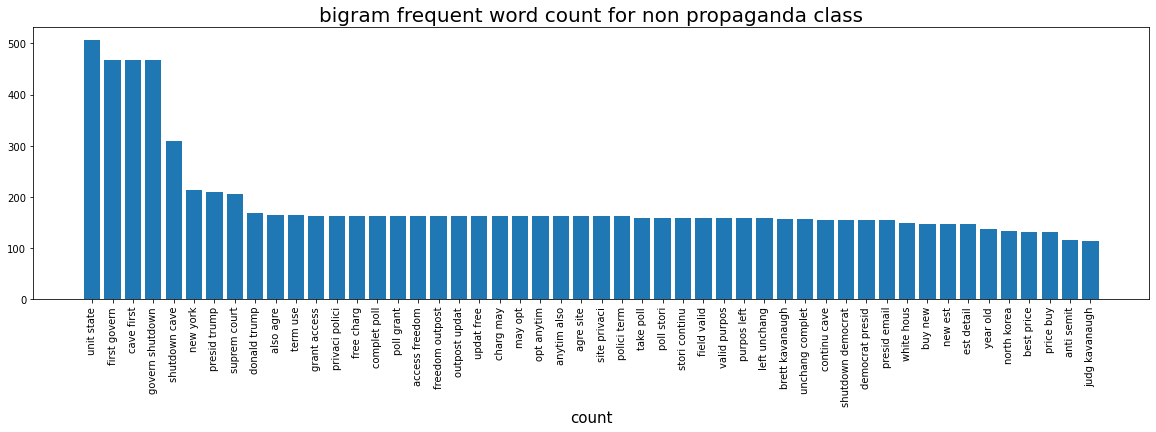

In [33]:
freq_ngrams(train_df[train_df['propaganda_label'] == -1]["preprop_text"], n_gram=2, range=50, 
            title="bigram frequent word count for propaganda class")
freq_ngrams(val_df[val_df['propaganda_label'] == 1]["preprop_text"], n_gram=2, range=50, 
            title="bigram frequent word count for non propaganda class")

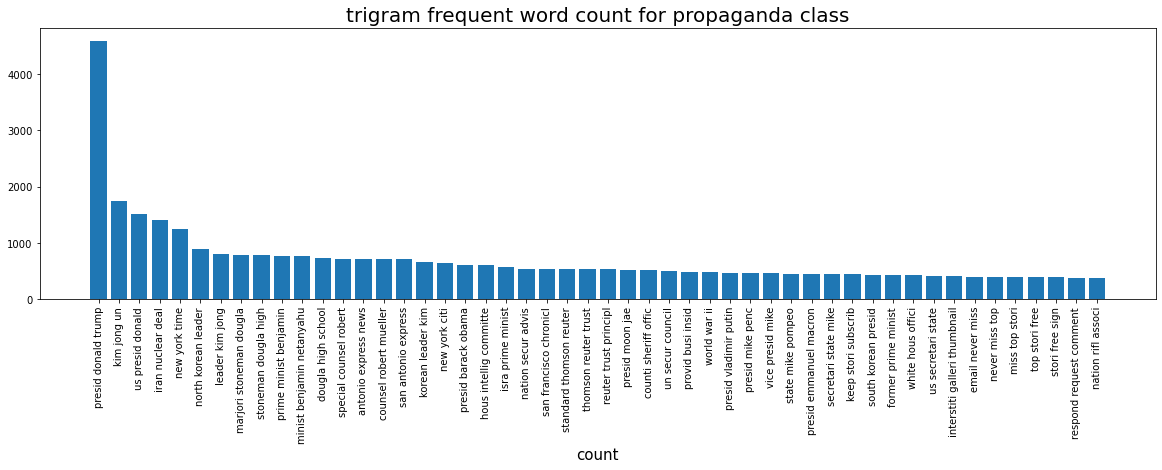

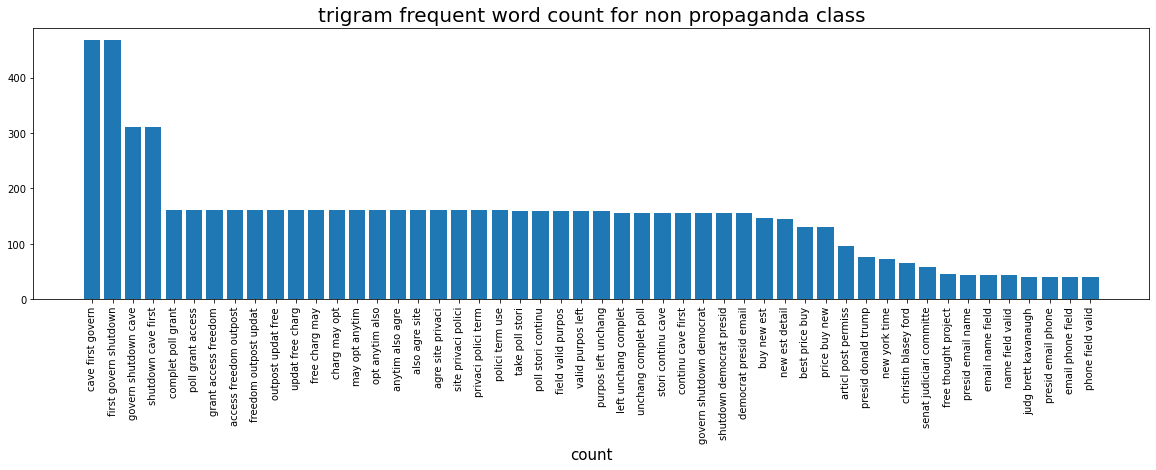

In [34]:
freq_ngrams(train_df[train_df['propaganda_label'] == -1]["preprop_text"], n_gram=3, range=50, 
            title="trigram frequent word count for propaganda class")
freq_ngrams(val_df[val_df['propaganda_label'] == 1]["preprop_text"], n_gram=3, range=50, 
            title="trigram frequent word count for non propaganda class")

## 8. tokenization of text

### 8.1 count vectorizer

In [35]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

## initializing count vectorizer
count_vect = CountVectorizer(analyzer='word', ngram_range=(1, 3), 
                             stop_words="english", min_df = 10, max_df = 0.95, max_features = 60000)
## fitting data
count_vect.fit(train_df["preprop_text"])

## transforming data
xtrain_count =  count_vect.transform(train_df["preprop_text"])
xval_count =  count_vect.transform(val_df["preprop_text"])
xtest_count =  count_vect.transform(test_df["preprop_text"])


print("shape")
print("xtrain : {}, xval : {}, xtest : {}".format(xtrain_count.shape, xval_count.shape, xtest_count.shape))

shape
xtrain : (35986, 60000), xval : (5125, 60000), xtest : (10159, 60000)
Wall time: 2min 18s


### 8.2 tfidf vectorizer

In [36]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

## initializing count vectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), 
                             stop_words="english", min_df = 10, max_df = 0.95, max_features = 60000)
## fitting data
tfidf_vect.fit(train_df["preprop_text"])

## transforming data
xtrain_tfidf =  tfidf_vect.transform(train_df["preprop_text"])
xval_tfidf =  tfidf_vect.transform(val_df["preprop_text"])
xtest_tfidf =  tfidf_vect.transform(test_df["preprop_text"])


print("shape")
print("xtrain : {}, xval : {}, xtest : {}".format(xtrain_tfidf.shape, xval_tfidf.shape, xtest_tfidf.shape))

shape
xtrain : (35986, 60000), xval : (5125, 60000), xtest : (10159, 60000)
Wall time: 2min 18s


In [37]:
## creating output data
ytrain = train_df['propaganda_label']
yval = val_df['propaganda_label']
ytest = test_df['propaganda_label']

## 9. Machine Learning Modelling

### 9.1 naive bayes classifier - count vectorizer

In [38]:
from sklearn.naive_bayes import MultinomialNB

## we are using multinomial naive bayes for the model building
multiNB_count = MultinomialNB()
param_grid = {'alpha': [10 ** x for x in range(-3, 3)]}

## using randomized search cv to get the best parameters
clf = RandomizedSearchCV(multiNB_count, param_grid, cv=3, scoring='f1', return_train_score=True, 
                         verbose=True, n_jobs=-1)
clf.fit(xtrain_count, ytrain)

print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best cross-validation score: 0.64
Best parameters:  {'alpha': 0.001}


----MultinomialNB with Count Vectorizer----

Overall accuracy score: 0.9307
Overall f1 score: 0.7349
Overall precision: 0.644
Overall recall: 0.8557

Classification Report:
               precision    recall  f1-score   support

          -1       0.98      0.94      0.96      4550
           1       0.64      0.86      0.73       575

    accuracy                           0.93      5125
   macro avg       0.81      0.90      0.85      5125
weighted avg       0.94      0.93      0.93      5125



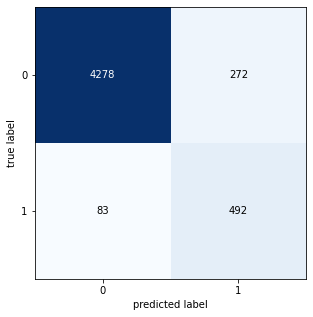

In [39]:
multiNB_count = MultinomialNB(alpha=clf.best_params_['alpha'])
multiNB_count.fit(xtrain_count, ytrain)
ypred = multiNB_count.predict(xval_count)

print("----MultinomialNB with Count Vectorizer----\n")
print("Overall accuracy score:",round((metrics.accuracy_score(yval, ypred)),4))
print("Overall f1 score:",round((metrics.f1_score(yval,ypred)),4))
print("Overall precision:",round((metrics.precision_score(yval,ypred)),4))
print("Overall recall:",round((metrics.recall_score(yval,ypred)),4))

print("\nClassification Report:\n",metrics.classification_report(yval,ypred))

fig, ax = plot_confusion_matrix(conf_mat=metrics.confusion_matrix(yval,ypred), figsize=(5, 5))
plt.show()

### 9.2 naive bayes classifier - tfidf vectorizer

In [40]:
## we are using multinomial naive bayes for the model building
multiNB_tfidf = MultinomialNB()
param_grid = {'alpha': [10 ** x for x in range(-3, 3)]}

## using randomized search cv to get the best parameters
clf = RandomizedSearchCV(multiNB_tfidf, param_grid, cv=3, scoring='f1', return_train_score=True, 
                         verbose=True, n_jobs=-1)
clf.fit(xtrain_tfidf, ytrain)

print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best cross-validation score: 0.64
Best parameters:  {'alpha': 0.001}


----MultinomialNB with tfidf Vectorizer----

Overall accuracy score: 0.9543
Overall f1 score: 0.7955
Overall precision: 0.7996
Overall recall: 0.7913

Classification Report:
               precision    recall  f1-score   support

          -1       0.97      0.97      0.97      4550
           1       0.80      0.79      0.80       575

    accuracy                           0.95      5125
   macro avg       0.89      0.88      0.88      5125
weighted avg       0.95      0.95      0.95      5125



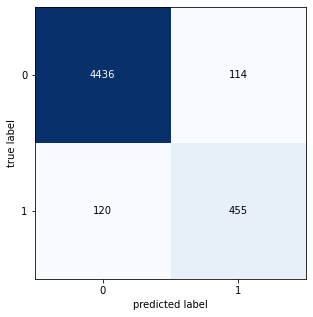

In [41]:
multiNB_tfidf = MultinomialNB(alpha=clf.best_params_['alpha'])
multiNB_tfidf.fit(xtrain_tfidf, ytrain)
ypred = multiNB_tfidf.predict(xval_tfidf)

print("----MultinomialNB with tfidf Vectorizer----\n")
print("Overall accuracy score:",round((metrics.accuracy_score(yval, ypred)),4))
print("Overall f1 score:",round((metrics.f1_score(yval,ypred)),4))
print("Overall precision:",round((metrics.precision_score(yval,ypred)),4))
print("Overall recall:",round((metrics.recall_score(yval,ypred)),4))

print("\nClassification Report:\n",metrics.classification_report(yval,ypred))

fig, ax = plot_confusion_matrix(conf_mat=metrics.confusion_matrix(yval,ypred), figsize=(5, 5))
plt.show()

### 9.3 Logistic Regression - count vectorizer

In [42]:
from sklearn.linear_model import LogisticRegression

## initializing logistic regression
logisticR_count = LogisticRegression(penalty='l2',n_jobs = -1)
param_grid = {'C' : [10 ** x for x in range(-3,3)]}

clf = RandomizedSearchCV(logisticR_count, param_grid, scoring='f1', return_train_score=True, 
                   verbose=True, n_jobs=-1)
clf.fit(xtrain_count, ytrain)

print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best cross-validation score: 0.67
Best parameters:  {'C': 10}


----Logistic Regression with Count Vectorizer----

Overall accuracy score: 0.968
Overall f1 score: 0.8551
Overall precision: 0.8689
Overall recall: 0.8417

Classification Report:
               precision    recall  f1-score   support

          -1       0.98      0.98      0.98      4550
           1       0.87      0.84      0.86       575

    accuracy                           0.97      5125
   macro avg       0.92      0.91      0.92      5125
weighted avg       0.97      0.97      0.97      5125



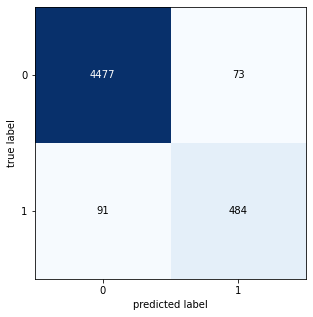

In [43]:
logisticR_count = LogisticRegression(penalty='l2', C=clf.best_params_['C'], n_jobs = -1)
logisticR_count.fit(xtrain_count, ytrain)
ypred = logisticR_count.predict(xval_count)

print("----Logistic Regression with Count Vectorizer----\n")
print("Overall accuracy score:",round((metrics.accuracy_score(yval, ypred)),4))
print("Overall f1 score:",round((metrics.f1_score(yval,ypred)),4))
print("Overall precision:",round((metrics.precision_score(yval,ypred)),4))
print("Overall recall:",round((metrics.recall_score(yval,ypred)),4))

print("\nClassification Report:\n",metrics.classification_report(yval,ypred))

fig, ax = plot_confusion_matrix(conf_mat=metrics.confusion_matrix(yval,ypred), figsize=(5, 5))
plt.show()

### 9.4 Logistic Regression - tfidf vectorizer

In [44]:
logisticR_tfidf = LogisticRegression(penalty='l2',n_jobs = -1)
param_grid = {'C' : [10 ** x for x in range(-3,3)]}

clf = RandomizedSearchCV(logisticR_tfidf, param_grid, scoring='f1', return_train_score=True, 
                   verbose=True, n_jobs=-1)
clf.fit(xtrain_tfidf, ytrain)

print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best cross-validation score: 0.68
Best parameters:  {'C': 100}


----Logistic Regression with tfidf Vectorizer----

Overall accuracy score: 0.9727
Overall f1 score: 0.873
Overall precision: 0.9127
Overall recall: 0.8365

Classification Report:
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98      4550
           1       0.91      0.84      0.87       575

    accuracy                           0.97      5125
   macro avg       0.95      0.91      0.93      5125
weighted avg       0.97      0.97      0.97      5125



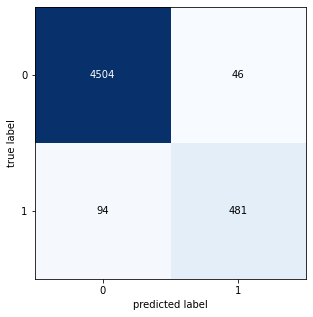

In [45]:
logisticR_tfidf = LogisticRegression(penalty='l2', C=clf.best_params_['C'], n_jobs = -1)
logisticR_tfidf.fit(xtrain_tfidf, ytrain)
ypred = logisticR_tfidf.predict(xval_tfidf)

print("----Logistic Regression with tfidf Vectorizer----\n")
print("Overall accuracy score:",round((metrics.accuracy_score(yval, ypred)),4))
print("Overall f1 score:",round((metrics.f1_score(yval,ypred)),4))
print("Overall precision:",round((metrics.precision_score(yval,ypred)),4))
print("Overall recall:",round((metrics.recall_score(yval,ypred)),4))

print("\nClassification Report:\n",metrics.classification_report(yval,ypred))

fig, ax = plot_confusion_matrix(conf_mat=metrics.confusion_matrix(yval,ypred), figsize=(5, 5))
plt.show()

### 9.5 Support Vector Machine - count vectorizer

In [46]:
from sklearn.svm import LinearSVC

linearsvc_count = LinearSVC(penalty='l2', loss='squared_hinge')
param_grid = {'C' : [10 ** x for x in range(-3, 3)]}

clf = RandomizedSearchCV(linearsvc_count, param_grid, cv=3, scoring='f1', return_train_score=True, 
                   verbose=True, n_jobs=-1)
clf.fit(xtrain_count, ytrain)

print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best cross-validation score: 0.67
Best parameters:  {'C': 0.01}


----SVM with Count Vectorizer----

Overall accuracy score: 0.9659
Overall f1 score: 0.8472
Overall precision: 0.8509
Overall recall: 0.8435

Classification Report:
               precision    recall  f1-score   support

          -1       0.98      0.98      0.98      4550
           1       0.85      0.84      0.85       575

    accuracy                           0.97      5125
   macro avg       0.92      0.91      0.91      5125
weighted avg       0.97      0.97      0.97      5125



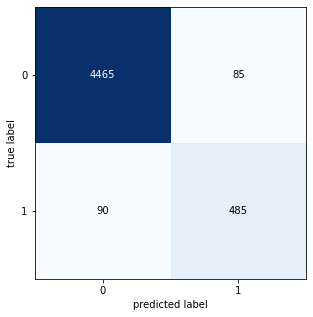

In [47]:
linearsvc_count = LinearSVC(penalty='l2', loss='squared_hinge', C=clf.best_params_['C'])
linearsvc_count.fit(xtrain_count, ytrain)
ypred = linearsvc_count.predict(xval_count)

print("----SVM with Count Vectorizer----\n")
print("Overall accuracy score:",round((metrics.accuracy_score(yval, ypred)),4))
print("Overall f1 score:",round((metrics.f1_score(yval,ypred)),4))
print("Overall precision:",round((metrics.precision_score(yval,ypred)),4))
print("Overall recall:",round((metrics.recall_score(yval,ypred)),4))

print("\nClassification Report:\n",metrics.classification_report(yval,ypred))

fig, ax = plot_confusion_matrix(conf_mat=metrics.confusion_matrix(yval,ypred), figsize=(5, 5))
plt.show()

### 9.6 Support Vector Machine - tfidf vectorizer

In [48]:
linearsvc_tfidf = LinearSVC(penalty='l2', loss='squared_hinge')
param_grid = {'C' : [10 ** x for x in range(-3, 3)]}

clf = RandomizedSearchCV(linearsvc_tfidf, param_grid, cv=3, scoring='f1', return_train_score=True, 
                   verbose=True, n_jobs=-1)
clf.fit(xtrain_tfidf, ytrain)

print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best cross-validation score: 0.68
Best parameters:  {'C': 10}


----SVM with tfidf Vectorizer----

Overall accuracy score: 0.9721
Overall f1 score: 0.8731
Overall precision: 0.8913
Overall recall: 0.8557

Classification Report:
               precision    recall  f1-score   support

          -1       0.98      0.99      0.98      4550
           1       0.89      0.86      0.87       575

    accuracy                           0.97      5125
   macro avg       0.94      0.92      0.93      5125
weighted avg       0.97      0.97      0.97      5125



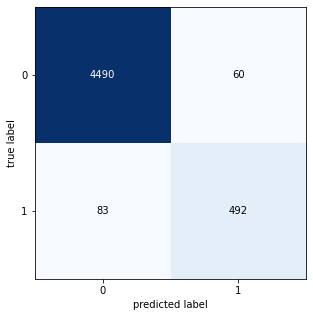

In [49]:
linearsvc_tfidf = LinearSVC(penalty='l2', loss='squared_hinge', C=clf.best_params_['C'])
linearsvc_tfidf.fit(xtrain_tfidf, ytrain)
ypred = linearsvc_tfidf.predict(xval_tfidf)

print("----SVM with tfidf Vectorizer----\n")
print("Overall accuracy score:",round((metrics.accuracy_score(yval, ypred)),4))
print("Overall f1 score:",round((metrics.f1_score(yval,ypred)),4))
print("Overall precision:",round((metrics.precision_score(yval,ypred)),4))
print("Overall recall:",round((metrics.recall_score(yval,ypred)),4))

print("\nClassification Report:\n",metrics.classification_report(yval,ypred))

fig, ax = plot_confusion_matrix(conf_mat=metrics.confusion_matrix(yval,ypred), figsize=(5, 5))
plt.show()

## 10. Deep Learning Model

### 10.1 Importing Libraries

In [50]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Embedding
from tensorflow.keras.layers import SpatialDropout1D, LSTM, Activation, Bidirectional, Concatenate

### 10.2 loading embedding matrix

In [51]:
def embedding(file_path):
    '''
    parameter : file_path(embedding file)
    return : embedding_matrix(dictionary)
    '''
    with open(file_path, encoding="utf-8") as f:
        return {line.split(' ')[0] : np.asarray(line.split(' ')[1:],'float32') for line in tqdm(f)}

In [52]:
emb_path = "C:/Users/dell/Desktop/MRP/Codes/faheem/glove.840B.300d.txt"

In [54]:
embedding_matrix = embedding(emb_path)

0it [00:00, ?it/s]

### 10.3 checking the vocabulary present in the actual data

In [55]:
def vocab_generator(data):
    dictionary = defaultdict(int)
    total_sent = data.apply(lambda x: x.split()).values
    for sent in tqdm(total_sent):
        for token in sent:
            dictionary[token] += 1
    return dictionary

In [56]:
#checking coverage for words present in vocabulary and in embedding_matrix
def coverage(vocab, embeddings_index):
    #Initializing values
    known_words = defaultdict(int)
    unknown_words = defaultdict(int)
    knownWordsVal = 0
    unknownWordsVal = 0
    #iterating words
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            knownWordsVal += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            unknownWordsVal += vocab[word]
            pass
    
    #printing values
    print('Found {:.2%} of words in the embedding of the vocab'.format(len(known_words) / len(vocab)))
    print('Found {:.2%} of the words in the vocab'.format(knownWordsVal / (knownWordsVal + unknownWordsVal)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [57]:
## creating the vocabulary
vocab = vocab_generator(train_df["final_text"]) 
## getting all the unknown words present in the data which is not present in embedding
oov_words = coverage(vocab, embedding_matrix) 

  0%|          | 0/35986 [00:00<?, ?it/s]

Found 28.33% of words in the embedding of the vocab
Found 88.57% of the words in the vocab


- The above code shows the total unique words present in the vocab which is also present in the embedding matrix, along with total words present in the vocab also present in the embedding matrix.

In [58]:
## printing top 30 out of vocabulary words
print(oov_words[0:30])

[('said,', 9512), ('“The', 8637), ('“I', 7610), ('it’s', 7298), ('don’t', 6602), ('Trump’s', 6107), ('"The', 6080), ('“We', 5960), ('"I', 5786), ('year,', 5404), ('"We', 4809), ('However,', 4802), ("Trump's", 4350), ('It’s', 4335), ('years,', 3998), ('didn’t', 3894), ('time,', 3672), ('that,', 3484), ('however,', 3164), ('doesn’t', 2966), ('2017,', 2839), ('2016,', 2832), ('that’s', 2804), ('week,', 2798), ('“It', 2756), ('I’m', 2577), ('people,', 2568), ('Trump,', 2506), ('“This', 2412), ('can’t', 2384)]


## 11 text preprocessing based on embedding matrix

### 11.1 decontraction

In [59]:
#some of the known contractions
contractions = {"'aight": 'alright', "ain't": 'am not', "amn't": 'am not', "aren't": 'are not', "can't": 'can not', "'cause": 
                'because', "could've": 'could have', "couldn't": 'could not', "couldn't've": 'could not have', "daren't": 
                'dare not', "daresn't": 'dare not', "dasn't": 'dare not', "didn't": 'did not', "doesn't": 'does not', 
                "don't": 'do not', 'dunno': "don't know", "d'ye": 'do you', "e'er": 'ever', "everybody's": 'everybody is', 
                "everyone's": 'everyone is', 'finna': 'fixing to', "g'day": 'good day', 'gimme': 'give me', "giv'n": 'given', 
                'gonna': 'going to', "gon't": 'go not', 'gotta': 'got to', "hadn't": 'had not', "had've": 'had have', 
                "hasn't": 'has not', "haven't": 'have not', "he'd": 'he had', "he'll": 'he will', "he's": 'he is', 
                "he've": 'he have', "how'd": 'how did', 'howdy': 'how do you do', "how'll": 'how will', "how're": 'how are', 
                "how's": 'how is', "I'd": 'I had', "I'd've": 'I would have', "I'll": 'I will', "I'm": 'I am', 
                "I'm'a": 'I am about to', "I'm'o": 'I am going to', 'innit': 'is it not', "I've": 'I have', "isn't": 'is not', 
                "it'd ": 'it would', "it'll": 'it will', "it's ": 'it is', 'iunno': "I don't know", "let's": 'let us', 
                "ma'am": 'madam', "mayn't": 'may not', "may've": 'may have', 'methinks': 'me thinks', "mightn't": 'might not', 
                "might've": 'might have', "mustn't": 'must not', "mustn't've": 'must not have', "must've": 'must have', 
                "needn't": 'need not', 'nal': 'and all', "ne'er": 'never', "o'clock": 'of the clock', "o'er": 'over',
                "ol'": 'old', "oughtn't": 'ought not', "'s": 'is', "shalln't": 'shall not', "shan't": 'shall not', 
                "she'd": 'she would', "she'll": 'she will', "she's": 'she is', "should've": 'should have', 
                "shouldn't": 'should not', "shouldn't've": 'should not have', "somebody's": 'somebody has', 
                "someone's": 'someone has', "something's": 'something has', "so're": 'so are', "that'll": 'that will', 
                "that're": 'that are', "that's": 'that is', "that'd": 'that would', "there'd": 'there would', 
                "there'll": 'there will', "there're": 'there are', "there's": 'there is', "these're": 'these are', 
                "they've": 'they have', "this's": 'this is', "those're": 'those are', "those've": 'those have', "'tis": 'it is', 
                "to've": 'to have', "'twas": 'it was', 'wanna': 'want to', "wasn't": 'was not', "we'd": 'we would', 
                "we'd've": 'we would have', "we'll": 'we will', "we're": 'we are', "we've": 'we have', "weren't": 'were not', 
                "what'd": 'what did', "what'll": 'what will', "what're": 'what are', "what's": 'what does', "what've": 'what have',
                "when's": 'when is', "where'd": 'where did', "where'll": 'where will', "where're": 'where are',
                "where's": 'where is',"where've": 'where have', "which'd": 'which would', "which'll": 'which will', 
                "which're": 'which are',"which's": 'which is', "which've": 'which have', "who'd": 'who would',
                "who'd've": 'who would have', "who'll": 'who will', "who're": 'who are', "who'ves": 'who is', "who'": 'who have',
                "why'd": 'why did', "why're": 'why are', "why's": 'why does', "willn't": 'will not', "won't": 'will not',
                'wonnot': 'will not', "would've": 'would have', "wouldn't": 'would not', "wouldn't've": 'would not have',
                "y'all": 'you all', "y'all'd've": 'you all would have', "y'all'd'n've": 'you all would not have',
                "y'all're": 'you all are', "cause":"because","have't":"have not","cann't":"can not","ain't":"am not",
                "you'd": 'you would', "you'll": 'you will', "you're": 'you are', "you've": 'you have', 'cannot': 'can not', 
                'wont': 'will not', "You'": 'Am not', "Ain'": 'Am not', "Amn'": 'Am not', "Aren'": 'Are not',
                "Can'": 'Because', "Could'": 'Could have', "Couldn'": 'Could not have', "Daren'": 'Dare not', 
                "Daresn'": 'Dare not', "Dasn'": 'Dare not', "Didn'": 'Did not', "Doesn'": 'Does not', "Don'": "Don't know", 
                "D'": 'Do you', "E'": 'Ever', "Everybody'": 'Everybody is', "Everyone'": 'Fixing to', "G'": 'Give me', 
                "Giv'": 'Going to', "Gon'": 'Got to', "Hadn'": 'Had not', "Had'": 'Had have', "Hasn'": 'Has not', 
                "Haven'": 'Have not', "He'": 'He have', "How'": 'How is', "I'": 'I have', "Isn'": 'Is not', "It'": "I don't know", 
                "Let'": 'Let us', "Ma'": 'Madam', "Mayn'": 'May not', "May'": 'Me thinks', "Mightn'": 'Might not', 
                "Might'": 'Might have', "Mustn'": 'Must not have', "Must'": 'Must have', "Needn'": 'And all', "Ne'": 'Never',
                "O'": 'Old', "Oughtn'": 'Is', "Shalln'": 'Shall not', "Shan'": 'Shall not', "She'": 'She is', 
                "Should'": 'Should have', "Shouldn'": 'Should not have', "Somebody'": 'Somebody has', "Someone'": 'Someone has', 
                "Something'": 'Something has', "So'": 'So are', "That'": 'That would', "There'": 'There is',
                "They'": 'They have', "This'": 'This is', "Those'": 'It is', "To'": 'Want to', "Wasn'": 'Was not',
                "Weren'": 'Were not', "What'": 'What have', "When'": 'When is', "Where'": 'Where have', "Which'": 'Which have', 
                "Who'": 'Who have', "Why'": 'Why does', "Willn'": 'Will not', "Won'": 'Will not', "Would'": 'Would have',
                "Wouldn'": 'Would not have', "Y'": 'You all are',"What's":"What is","What're":"What are","what's":"what is",
                "what're":"what are", "Who're":"Who are", "your're":"you are","you're":"you are", "You're":"You are",
                "We're":"We are", "These'": 'These have', "we're":"we are","Why're":"Why are","How're":"How are ",
                "how're ":"how are ","they're ":"they are ", "befo're":"before","'re ":" are ",'don"t ':"do not", 
                "Won't ":"Will not ","could't":"could not", "would't":"would not", "We'": 'We have',"Hasn't":"Has not",
                "n't":"not", 'who"s':"who is"}

def decontraction(data, contractions): 
    for idx,val in enumerate(data):
        val = ' '.join(word.replace(word,contractions[word]) if word in contractions
                       else word for word in val.split())
        val = val.replace('”', '"'); val = val.replace("’", "'")
        val = re.sub(r"\'s", " ", val); val = re.sub(r"n\'t", " not ", val)
        val = re.sub(r"\'re ", " are ", val); val = re.sub(r"\'d ", " would", val)
        val = re.sub(r"\'ll ", " will", val); val = re.sub(r"\'ve ", " have", val)
        val = re.sub(r"\'m ", " am", val); val = re.sub("\s{2}"," ",val)
        data[idx] = val.strip()
    return data

In [60]:
train_df['preprop_text_emb'] = decontraction(train_df['final_text'], contractions)
val_df['preprop_text_emb'] = decontraction(val_df['final_text'], contractions)
test_df['preprop_text_emb'] = decontraction(test_df['final_text'], contractions)

In [61]:
vocab = vocab_generator(train_df["preprop_text_emb"]) 
oov_words = coverage(vocab, embedding_matrix) 

  0%|          | 0/35986 [00:00<?, ?it/s]

Found 30.22% of words in the embedding of the vocab
Found 89.86% of the words in the vocab


### 11.2 removal of stopwords

In [62]:
## removal of stopwords present in the stopwords object
print(stopwords)

train_df["preprop_text_emb"] = train_df["preprop_text_emb"].apply(
    lambda x : ' '.join(e for e in x.split() if e not in stopwords))

val_df["preprop_text_emb"] = val_df["preprop_text_emb"].apply(
    lambda x : ' '.join(e for e in x.split() if e not in stopwords))

test_df["preprop_text_emb"] = test_df["preprop_text_emb"].apply(
    lambda x : ' '.join(e for e in x.split() if e not in stopwords))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### 11.3 punctuation and special character

In [63]:
def character_removal(data, chars):
    for char in chars:
        if char in data:
            data = data.replace(char," ")
            data = data.replace('”', ' '); data = data.replace("‘", " ")
            data = re.sub("\s+"," ",data)
    return data

In [64]:
## specing of characters
train_df["preprop_text_emb"] = train_df["preprop_text_emb"].apply(lambda x: character_removal(x, string.punctuation))
val_df["preprop_text_emb"] = val_df["preprop_text_emb"].apply(lambda x: character_removal(x, string.punctuation))
test_df["preprop_text_emb"] = test_df["preprop_text_emb"].apply(lambda x: character_removal(x, string.punctuation))

In [65]:
## after preprocessing
vocab = vocab_generator(train_df["preprop_text_emb"])
oov_words = coverage(vocab, embedding_matrix)

  0%|          | 0/35986 [00:00<?, ?it/s]

Found 68.10% of words in the embedding of the vocab
Found 98.01% of the words in the vocab


In [66]:
print(oov_words)

[('“I', 9216), ('“The', 8872), ('“We', 7144), ('“It', 5016), ('“This', 2441), ('“the', 2275), ('Brexit', 2180), ('“There', 1781), ('“If', 1724), ('“a', 1566), ('“They', 1546), ('“He', 1521), ('JCPOA', 1293), ('“You', 1249), ('“In', 1226), ('Daesh', 1174), ('taboola', 1025), ('“But', 965), ('“What', 872), ('“That', 855), ('“A', 834), ('“When', 829), ('“And', 767), ('“As', 697), ('havegot', 648), ('“Our', 639), ('“My', 638), ('“She', 599), ('“No', 521), ('“to', 521), ('Avenatti', 509), ('realDonaldTrump', 508), ('“So', 505), ('“These', 480), ('“no', 453), ('Strzok', 444), ('“For', 407), ('“not', 372), ('“is', 369), ('“At', 367), ('“All', 367), ('“we', 364), ('“very', 359), ('“in', 346), ('“To', 338), ('“it', 337), ('£100k', 332), ('“an', 330), ('Manbij', 302), ('“One', 298), ('“People', 296), ('“How', 294), ('postmedia', 293), ('“Do', 273), ('“With', 267), ('“While', 266), ('“Why', 264), ('articleGUID', 259), ('“Now', 250), ('“was', 242), ('“has', 239), ('©2018', 236), ('Warmbier', 235),

## 12. parameter setting

In [67]:
## checking percentile for sentence length
train_df['preprop_text_emb'].apply(lambda x : len(x.split())).describe([0, 0.2, 0.4, 0.6, 0.8, 0.9,0.92, 0.94, 0.96, 
                                                                        0.98, 0.99, 0.991, 0.993, 0.995, 0.997, 0.999, 1]).transpose()

count    35986.000000
mean       380.432974
std        316.530623
min          8.000000
0%           8.000000
20%        165.000000
40%        257.000000
50%        306.000000
60%        366.000000
80%        544.000000
90%        709.000000
92%        761.000000
94%        832.000000
96%        944.000000
98%       1164.300000
99%       1485.150000
99.1%     1537.000000
99.3%     1688.105000
99.5%     1854.075000
99.7%     2182.045000
99.9%     3241.015000
100%     12450.000000
max      12450.000000
Name: preprop_text_emb, dtype: float64

- As we can see there are some sentences with more than 1000 tokens.
- As rnn models lstm and gru cant handle such long dependencies we must limit maximum length of sentence to 800.

In [68]:
maxlen = 800
emb_dim = 300
lstm_units = 128

## 13. Encoding of data

In [69]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer() ## creating object for tokenization
tokenizer.fit_on_texts(train_df["preprop_text_emb"])
train_tokens = tokenizer.texts_to_sequences(train_df["preprop_text_emb"])
val_tokens = tokenizer.texts_to_sequences(val_df["preprop_text_emb"])
test_tokens = tokenizer.texts_to_sequences(test_df["preprop_text_emb"])

## 14. Sequence padding of data

In [70]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

## padding of text data with maximum length with 800 tokens
train_pad = pad_sequences(train_tokens, maxlen = maxlen, padding='post')
val_pad = pad_sequences(val_tokens, maxlen = maxlen, padding='post')
test_pad = pad_sequences(test_tokens, maxlen = maxlen, padding='post')

In [71]:
print(train_pad.shape, val_pad.shape, test_pad.shape)
print(train_pad[0])

(35986, 800) (5125, 800) (10159, 800)
[  3603    819   8292    814    819   5415  19291  91352     17    247
   3603  15076   2148  52214    815     23    408    896   2068   1344
   5303  38136   3858  34190    121    255    971     23    174   8292
    814      6   1317    412   8310  77300     14     40  12973   6447
      1     14     48   2582   5120    891   7503    301    372  25949
   8310      1   2148    159    508    385   8292    814   1017    301
    891     43   1114   2615   2068   8292    814   7951   3185    992
     46   2068   3787      1  77301  10341   2396   5230  19557   2980
    992    390     41    212    273   1635   3788   1319   8292    814
     32   2068   8292    814   1229    356   2232    356  11272   2100
   9081   2184   2584      8     50  11104    449    148   2240   2068
     51    623   1045   2068   8292    814  52215    977   5047   6435
    742   1018   3061   3248  14840     89    259   2356    347   8596
     17   7582   8292    814   2357   1

## 15. embedding vocabulary

In [72]:
vocab_size = len(tokenizer.word_index) + 1

words = set(embedding_matrix.keys())
emb_mtrx_glove = np.zeros((vocab_size, emb_dim))
for word, idx in tokenizer.word_index.items():
    if word in words:
        embedding_vector = embedding_matrix[word]
        emb_mtrx_glove[idx] = embedding_vector

print('The shape of emdedding matrix is: ',emb_mtrx_glove.shape)

The shape of emdedding matrix is:  (207933, 300)


## 16. output data one hot encodding

In [73]:
## one hot encoding for output labels
ytrain = train_df['propaganda_label'].apply(lambda x : 0 if x == -1 else 1)
yval = val_df['propaganda_label'].apply(lambda x : 0 if x == -1 else 1)
ytest = test_df['propaganda_label'].apply(lambda x : 0 if x == -1 else 1)

y_train = tf.keras.utils.to_categorical(ytrain, 2)
y_val = tf.keras.utils.to_categorical(yval, 2)
y_test = tf.keras.utils.to_categorical(ytest, 2)

## getting shape
y_train.shape, y_val.shape, y_test.shape

((35986, 2), (5125, 2), (10159, 2))

## 17. callbacks

In [74]:
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

In [75]:
#Callback function
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.callbacks import Callback

class accuracy_value(Callback):

    def __init__(self,training_data,validation_data):
        self.X_train = training_data[0]
        self.y_train = training_data[1]
        self.X_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs = {}):
        self.f1_scores = []
        self.precisions = []
        self.recalls = []

    def on_epoch_end(self, epoch, logs = {}):
        #F1 Score
        y_predicted = np.asarray(self.model.predict(self.X_val)).round()
        f1_val = f1_score(self.y_val,y_predicted,average=None)
        self.f1_scores.append(f1_val)

        print(" - f1 score : {}".format(np.round(f1_val,4)))

f1Score = accuracy_value(training_data=(train_pad, y_train), validation_data=(val_pad, y_val))

## 18. LSTM model 

### 18.1 model architecture and compilation|

In [76]:
model = tf.keras.Sequential()
model.add(Embedding(vocab_size, emb_dim, weights = [emb_mtrx_glove], input_length = maxlen, trainable=False))
model.add(LSTM(64, kernel_initializer='glorot_normal', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2()))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2()))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

In [77]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"]) #compile the model
history = model.fit(train_pad, y_train, batch_size=512, verbose=1, epochs=20,  shuffle=True, validation_data=(val_pad, y_val),
          callbacks=[earlyStopping, f1Score])

Epoch 1/20
71/71 [==============================] - 662s 9s/step - loss: 2.9550 - accuracy: 0.9030 - val_loss: 0.8604 - val_accuracy: 0.9210
Epoch 2/20
71/71 [==============================] - 902s 13s/step - loss: 0.5775 - accuracy: 0.9306 - val_loss: 0.4627 - val_accuracy: 0.9118
Epoch 3/20
71/71 [==============================] - 1051s 15s/step - loss: 0.3556 - accuracy: 0.9345 - val_loss: 0.3138 - val_accuracy: 0.9403
Epoch 4/20
71/71 [==============================] - 1148s 16s/step - loss: 0.6070 - accuracy: 0.9125 - val_loss: 0.3280 - val_accuracy: 0.9235
Epoch 5/20
71/71 [==============================] - 1135s 16s/step - loss: 0.2958 - accuracy: 0.9341 - val_loss: 0.3072 - val_accuracy: 0.9303
Epoch 6/20
71/71 [==============================] - 1121s 16s/step - loss: 0.2627 - accuracy: 0.9378 - val_loss: 0.2678 - val_accuracy: 0.9372
Epoch 7/20
71/71 [==============================] - 1059s 15s/step - loss: 0.2498 - accuracy: 0.9417 - val_loss: 0.2783 - val_accuracy: 0.9335
Ep

In [78]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 800, 300)          62379900  
                                                                 
 lstm (LSTM)                 (None, 800, 64)           93440     
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1

### 18.2 plot

In [79]:
def plots(loss, accuracy, col, size):
    """
    This function provides the accuracy and loss plot for the model.
    """    
    fig, axes = plt.subplots(ncols = col, figsize=size)
    ## loss and accuray plot
    axes[0].plot(loss[0], color="r");  axes[0].plot(loss[1],  color="g")
    axes[1].plot(accuracy[0], color="r");  axes[1].plot(accuracy[1], color="g")

    ## title
    axes[0].set_title("Loss plot for train and validation dataset", fontsize=20)
    axes[1].set_title("Accuracy Plot for train and validation dataset", fontsize=20)
    
    ## ylabel
    axes[0].set_ylabel("Log Loss", fontsize=15)
    axes[1].set_ylabel("Accuracy", fontsize=15)

    ## legend
    axes[0].legend(["Train_Loss", "Validation_Loss"])
    axes[1].legend(["Train_Accuracy", "Validation_Accuracy"])

    ## iterating for ticks and xlabel
    for i in range(col):
        #setting up ticks
        axes[i].set_xticks(range(0,len(loss[0])))
        #setting up labels
        axes[i].set_xlabel("Number of Epochs", fontsize=15)
        axes[i].grid()
    
    return plt.show()

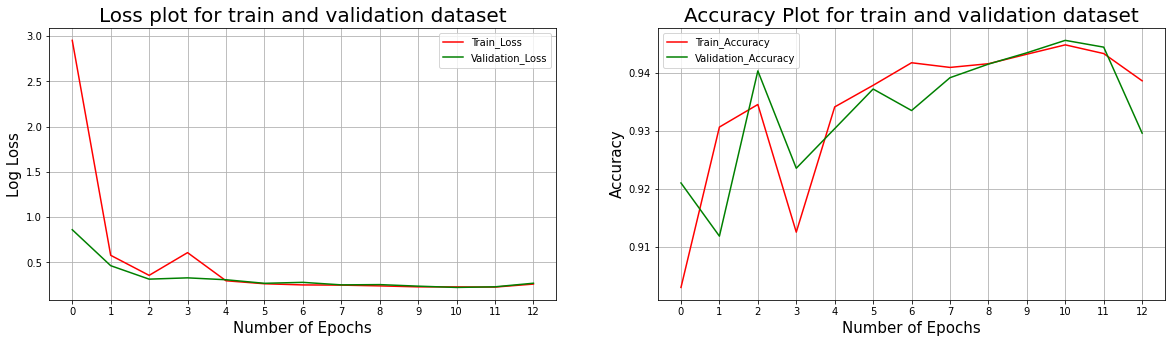

In [80]:
plots([history.history["loss"], history.history["val_loss"]], 
      [history.history["accuracy"], history.history["val_accuracy"]], 2, (20,5))

### 18.3 prediction

In [81]:
## predicting values
yval_pred = [max(enumerate(val), key=operator.itemgetter(1))[0] for val in model.predict(val_pad, verbose=1)]

161/161 [==============================] - 37s 230ms/step


In [82]:
acc = metrics.accuracy_score(yval, yval_pred) * 100
f1 = metrics.f1_score(yval, yval_pred) * 100
pre = metrics.precision_score(yval, yval_pred) * 100
rec = metrics.recall_score(yval, yval_pred) * 100

print("Overall Scores, accuracy -- {:.2f}, f1_score -- {:.2f}, precision -- {:.2f}, recall -- {:.2f}.".format(acc, f1, pre, rec))

Overall Scores, accuracy -- 92.96, f1_score -- 68.64, precision -- 68.58, recall -- 68.70.


In [83]:
print("Classification Report:\n",metrics.classification_report(yval, yval_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      4550
           1       0.69      0.69      0.69       575

    accuracy                           0.93      5125
   macro avg       0.82      0.82      0.82      5125
weighted avg       0.93      0.93      0.93      5125



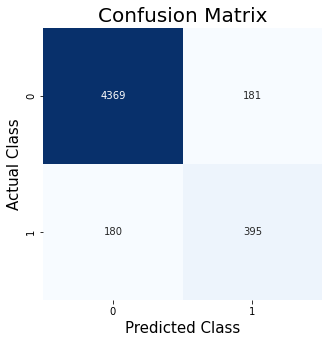

In [84]:
#getting confusion metrix
conf_matrix = metrics.confusion_matrix(yval, yval_pred)

fig = plt.figure(figsize=(5,5))
plot = sns.heatmap(conf_matrix, annot=True, cmap ="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Class", fontsize=15)
plt.ylabel("Actual Class", fontsize=15)
plt.title("Confusion Matrix", fontsize=20)
plt.show()

## 19. Attention LSTM Model

### 19.1 model architecture

In [85]:
class Attention(tf.keras.layers.Layer):
    '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self, att_units, name=None, **kwargs):
        super(Attention, self).__init__(name=name)
        #number of attention units to be provided
        self.att_units = att_units
        super(Attention, self).__init__(**kwargs)
        
        # Intialize variables needed for Concat score function here
        self.W1=tf.keras.layers.Dense(att_units)
        self.W2=tf.keras.layers.Dense(att_units)
        self.V=tf.keras.layers.Dense(1)

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({"att_units": self.att_units})
        return config

    def call(self,lstm_output, hidden_state):
        
        """
        hidden state shape == (batch_size, hidden size)
        lstm output shape == (batch_size, max_length, hidden size)
        """
        
        #state_with_time_axis shape == (batch_size, 1, hidden size)
        #we are doing this to broadcast addition along the time axis to calculate the score
        state_with_time_axis = tf.expand_dims(hidden_state, 1)
        
        #score shape == (batch_size, max_length, 1)
        #we get 1 at the last axis because we are applying score to self.V
        #the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(state_with_time_axis) + self.W2(lstm_output)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights=tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights*lstm_output
        context_vector = tf.reduce_sum(context_vector, axis=1)  

        return context_vector, attention_weights

In [86]:
inputs = Input(shape=(maxlen,), dtype='int32', name='Input_Text')
Embedding_Layer = Embedding(vocab_size, emb_dim, weights = [emb_mtrx_glove], input_length = maxlen, trainable=False)(inputs)
lstm_output, fw_state_h, fw_state_c, bw_state_h, bw_state_c = Bidirectional(LSTM(64, return_sequences=True, return_state=True))(Embedding_Layer)
state_h = Concatenate()([fw_state_h, bw_state_h])
context_vector, attention_weights = Attention(10)(lstm_output, state_h)
dense = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(context_vector)
output = Dense(2, activation='sigmoid')(dense)
model_attention = Model(inputs,output)

In [87]:
model_attention.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"]) #compile the model
history_attention = model_attention.fit(train_pad, y_train, batch_size=512, verbose=1, epochs=20,  
                                        shuffle=True, validation_data=(val_pad, y_val),
                                        callbacks=[earlyStopping, f1Score]) #fitting the model 

Epoch 1/20
71/71 [==============================] - 2565s 36s/step - loss: 1.0436 - accuracy: 0.8926 - val_loss: 0.5317 - val_accuracy: 0.9056
Epoch 2/20
71/71 [==============================] - 3384s 48s/step - loss: 0.3560 - accuracy: 0.9199 - val_loss: 0.2516 - val_accuracy: 0.9243
Epoch 3/20
71/71 [==============================] - 3568s 50s/step - loss: 0.2075 - accuracy: 0.9336 - val_loss: 0.1885 - val_accuracy: 0.9333
Epoch 4/20
71/71 [==============================] - 3572s 50s/step - loss: 0.1601 - accuracy: 0.9461 - val_loss: 0.1586 - val_accuracy: 0.9434
Epoch 5/20
71/71 [==============================] - 3625s 51s/step - loss: 0.1390 - accuracy: 0.9526 - val_loss: 0.1509 - val_accuracy: 0.9450
Epoch 6/20
71/71 [==============================] - 3618s 51s/step - loss: 0.1285 - accuracy: 0.9566 - val_loss: 0.1407 - val_accuracy: 0.9491
Epoch 7/20
71/71 [==============================] - 3621s 51s/step - loss: 0.1170 - accuracy: 0.9614 - val_loss: 0.1311 - val_accuracy: 0.9541

### 19.2 plots

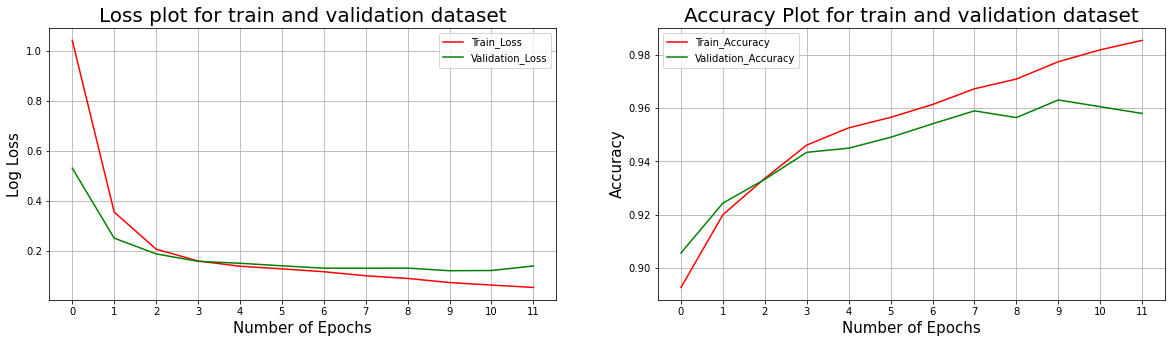

In [88]:
plots([history_attention.history["loss"], history_attention.history["val_loss"]], 
      [history_attention.history["accuracy"], history_attention.history["val_accuracy"]], 2, (20,5))

### 19.3 prediction

In [89]:
## predicting values
yval_pred = [max(enumerate(val), key=operator.itemgetter(1))[0] for val in model_attention.predict(val_pad, verbose=1)]

161/161 [==============================] - 159s 985ms/step


In [90]:
acc = metrics.accuracy_score(yval, yval_pred) * 100
f1 = metrics.f1_score(yval, yval_pred) * 100
pre = metrics.precision_score(yval, yval_pred) * 100
rec = metrics.recall_score(yval, yval_pred) * 100

print("Overall Scores, accuracy -- {:.2f}, f1_score -- {:.2f}, precision -- {:.2f}, recall -- {:.2f}.".format(acc, f1, pre, rec))

Overall Scores, accuracy -- 95.80, f1_score -- 81.64, precision -- 80.20, recall -- 83.13.


In [91]:
print("Classification Report:\n",metrics.classification_report(yval, yval_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      4550
           1       0.80      0.83      0.82       575

    accuracy                           0.96      5125
   macro avg       0.89      0.90      0.90      5125
weighted avg       0.96      0.96      0.96      5125



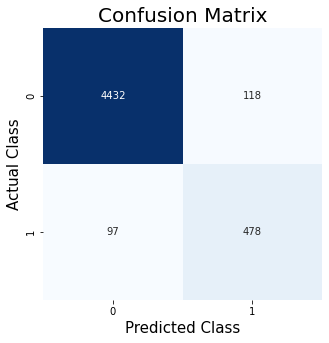

In [92]:
#getting confusion metrix
conf_matrix = metrics.confusion_matrix(yval, yval_pred)

fig = plt.figure(figsize=(5,5))
plot = sns.heatmap(conf_matrix, annot=True, cmap ="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Class", fontsize=15)
plt.ylabel("Actual Class", fontsize=15)
plt.title("Confusion Matrix", fontsize=20)
plt.show()